In [1]:
%load_ext autoreload
%autoreload 2
'''
This cell loads the model from the config file and initializes the viewer
'''
import torch
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import numpy as np
from nerfstudio.viewer.viewer import Viewer
from nerfstudio.configs.base_config import ViewerConfig
import cv2
from torchvision.transforms import ToTensor
from PIL import Image
from nerfstudio.utils import writer
import time
from threading import Lock
from nerfstudio.cameras.cameras import Cameras
from copy import deepcopy
from torchvision.transforms.functional import resize
from toad.zed import Zed
import warp as wp
from toad.optimization.rigid_group_optimizer import RigidGroupOptimizer
from toad.optimization.atap_loss import ATAPLoss
from toad.utils import *
from toad.hand_registration import HandRegistration
from toad.optimization.frame import Frame
wp.init()

# config = Path("outputs/buddha_empty/dig/2024-06-02_224243/config.yml")
# config = Path("outputs/nerfgun_poly_far/dig/2024-06-02_234451/config.yml")
# config = Path("outputs/scissors/dig/2024-06-03_135548/config.yml")#pretty decent
# config = Path("outputs/painter_sculpture/dig/2024-06-03_101237/config.yml")
# config = Path("outputs/wooden_drawer/dig/2024-06-03_160055/config.yml")#works on slide, wiggle is a bit shaky but not bad
# config = Path("outputs/sunglasses/dig/2024-06-03_161521/config.yml")#works, but some noise so rescanning
# config = Path("outputs/sunglasses3/dig/2024-06-03_175202/config.yml")# scan is much better, works well
# config = Path("outputs/charger_poly/dig/2024-06-03_164048/config.yml")#doesn't work, scan very noisy, rescanning
# config = Path("outputs/charger_poly3/dig/2024-06-03_173148/config.yml")
# config = Path("outputs/garfield_poly/dig/2024-06-03_183227/config.yml")#IS A BIT translucent, maybe bad?
# config = Path("outputs/charger_latch/dig/2024-06-05_101644/config.yml")#doesn't work
# config = Path("outputs/painter_t/dig/2024-06-05_103134/config.yml")#somewhat works, might be usable
# config = Path("outputs/sanitizer/dig/2024-06-03_ 222921/config.yml")
# config = Path("outputs/big_painter_t/dig/2024-06-05_122620/config.yml")
# config = Path("outputs/power_brick/dig/2024-06-05_125218/config.yml")#bad recon.....trying again
# config = Path("outputs/power_brick3_colmap/dig/2024-06-05_150027/config.yml")
# config = Path("outputs/panini/dig/2024-06-05_193512/config.yml")
# config = Path("outputs/cal_bear_naked/dig/2024-06-04_215034/config.yml")


config = Path("outputs/buddha_empty/dig/2024-06-09_173902/config.yml")#upscale 5
# config = Path("outputs/buddha_balls_poly/dig/2024-06-09_003734/config.yml")
# config = Path("outputs/cal_bear_naked/dig/2024-06-10_131301/config.yml")
# config = Path("outputs/sunglasses3/dig/2024-06-09_004411/config.yml")
# config = Path("outputs/garfield_poly/dig/2024-06-09_005651/config.yml")
# config = Path("outputs/nerfgun_poly_far/dig/2024-06-09_010536/config.yml")
# config = Path("outputs/scissors/dig/2024-06-10_133700/config.yml")

# config = Path("outputs/big_painter_t/dig/2024-06-09_011522/config.yml")
# config = Path("outputs/wooden_drawer/dig/2024-06-10_134919/config.yml")

# config = Path("outputs/nerfgun2/dig/2024-06-11_142428/config.yml")

OUTPUT_FOLDER = Path("renders/refactor/buddha_empty/")

HANDS = False

assert OUTPUT_FOLDER.stem in str(config), "Output folder name does not match config name"
OUTPUT_FOLDER.mkdir(exist_ok=True,parents=True)
train_config,pipeline,_,_ = eval_setup(config)

dino_loader = pipeline.datamanager.dino_dataloader
train_config.logging.local_writer.enable = False
# We need to set up the writer to track number of rays, otherwise the viewer will not calculate the resolution correctly
writer.setup_local_writer(train_config.logging, max_iter=train_config.max_num_iterations)
v = Viewer(ViewerConfig(default_composite_depth=False,num_rays_per_chunk=-1),config.parent,pipeline.datamanager.get_datapath(),pipeline,train_lock=Lock())
try:
    pipeline.load_state()
except FileNotFoundError:
    print("No state found, starting from scratch")
if HANDS:
    handreg = HandRegistration()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/justin/miniconda3/envs/please/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Warp 1.2.0 initialized:
   CUDA Toolkit 11.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4090" (24 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/justin/.cache/warp/1.2.0


[20:58:49] Auto image downscale factor of 1                                                 ]8;id=106167;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=645341;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

            Dataset is overriding orientation method to none                                ]8;id=88815;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=961829;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

            Dataset is overriding orientation method to none                                ]8;id=567815;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=379567;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

           Caching / undistorting train images                                            ]8;id=546979;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=823136;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#230\230]8;;\

Output()

Using cache found in /home/justin/.cache/torch/hub/facebookresearch_dinov2_main


Using layer norm
denoiser.1.weight loaded
denoiser.1.bias loaded
Dino data shape torch.Size([56, 66, 90, 64])
Loading instance feature model...


[20:58:51]  Dataset is overriding orientation method to none                                ]8;id=5345;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=93320;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

            Dataset is overriding orientation method to none                                ]8;id=36643;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=360670;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/buddha_empty/garfield/2024-06-02_223452/nerfstudio_models/step-000008000.ckpt

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/buddha_empty/dig/2024-06-09_173902/nerfstudio_models/step-000005999.ckpt

[20:58:52] disabled local writer                                                                           ]8;id=80678;file:///home/justin/nerfstudio/nerfstudio/utils/writer.py\writer.py]8;;\:]8;id=634351;file:///home/justin/nerfstudio/nerfstudio/utils/writer.py#186\186]8;;\

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:7007   │
│   Websocket │ ws://0.0.0.0:7007     │
│             ╵                       │
╰─────────────────────────────────────╯

[20:58:53] Caching / undistorting eval images                                             ]8;id=911622;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=119984;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#230\230]8;;\

Output()

In [2]:
"""
This cell defines a simple pose optimizer for learning a rigid transform offset given a gaussian model, star pose, and starting view
"""

def get_vid_frame(cap,timestamp):
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate the frame number based on the timestamp and fps
    frame_number = min(int(timestamp * fps),int(cap.get(cv2.CAP_PROP_FRAME_COUNT)-1))
    
    # Set the video position to the calculated frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    success, frame = cap.read()
    # convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

MATCH_RESOLUTION = 500
camera_input = 'iphone' # ['iphone','zed', 'iphone_vertical','zed_svo']
video_path = Path("motion_vids/buddha_empty_close.MOV")
svo_path = Path("motion_vids/sunglasses2.svo2")
start_time = .3

cam_pose = None
if cam_pose is None:
    H = np.eye(4)
    from viser import transforms as vtf
    H[:3,:3] = vtf.SO3.from_x_radians(np.pi/4).as_matrix()
    cam_pose = torch.from_numpy(H).float()[None,:3,:]#TODO ground truth cam to yumi
if camera_input == 'iphone':
    init_cam = Cameras(camera_to_worlds=cam_pose,fx = 1137.0,fy = 1137.0,cx = 1280.0/2,cy = 720/2,width=1280,height=720)
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
elif camera_input == 'iphone_vertical':
    init_cam = Cameras(camera_to_worlds=cam_pose,fy = 1137.0,fx = 1137.0,cy = 1280/2,cx = 720/2,height=1280,width=720)
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
elif camera_input in ['zed','zed_svo']:
    try:
        zed.cam.close()
        del zed
    except:
        pass
    finally:
        zed = Zed(recording_file=str(svo_path.absolute()) if camera_input == 'zed_svo' else None, start_time=start_time)
    fps = 30    
    left_rgb,_,_ = zed.get_frame(depth=False)
    K = zed.get_K()
    init_cam = Cameras(camera_to_worlds=cam_pose,fx = K[0,0],fy = K[1,1],cx = K[0,2],cy = K[1,2],width=left_rgb.shape[1],height=left_rgb.shape[0])
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
pipeline.model.eval()
with torch.no_grad():
    outputs = pipeline.model.get_outputs_for_camera(init_cam)
if pipeline.cluster_labels is not None:
    labels = pipeline.cluster_labels.int().cuda()
    group_masks = [(cid == labels).cuda() for cid in range(labels.max() + 1)]
else:
    labels = torch.zeros(pipeline.model.num_points).int().cuda()
    group_masks = [torch.ones(pipeline.model.num_points).bool().cuda()]
optimizer = RigidGroupOptimizer(pipeline.model,dino_loader,group_masks, group_labels = labels, dataset_scale = pipeline.datamanager.train_dataset._dataparser_outputs.dataparser_scale, render_lock = v.train_lock)
rgb_renders = [] 

Touch radius is 0.006164098029586212
Group 1 has 1043 neighbors
Group 2 has 101 neighbors
Group 3 has 4545 neighbors
Group 4 has 3874 neighbors
Group 5 has 623 neighbors
Group 6 has 840 neighbors


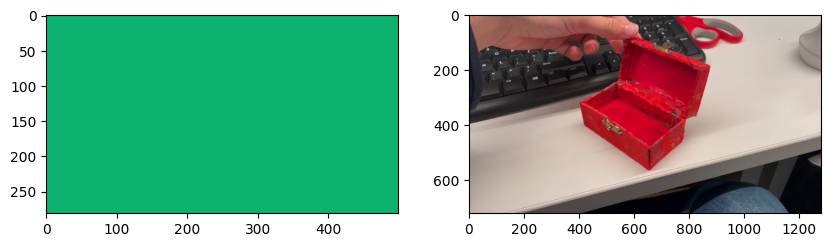

In [3]:
dino_fn = lambda x: dino_loader.get_pca_feats(x, keep_cuda=True)
if camera_input in ['zed','zed_svo']:
    left_rgb, right_rgb,depth = zed.get_frame()
    target_frame_rgb = (left_rgb/255)
    right_frame_rgb = (right_rgb/255)
    frame = Frame(target_frame_rgb, init_cam, dino_fn, metric_depth_img=depth)
else:
    assert video_path.exists()
    motion_clip = cv2.VideoCapture(str(video_path.absolute()))
    start=1.1
    end=3
    fps = 30
    frame = get_vid_frame(motion_clip,start)
    target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
    frame = Frame(target_frame_rgb, init_cam, dino_fn)
optimizer.set_frame(frame)
_,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(outputs["rgb"].detach().cpu().numpy())
axs[1].imshow(target_frame_rgb.cpu().numpy())

In [5]:
import moviepy.editor as mpy
xs,ys,outputs,renders = optimizer.initialize_obj_pose(render=True,niter=150,n_seeds=5)
_,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(outputs["rgb"].detach().cpu().numpy())
rescale = max(target_frame_rgb.shape[0],target_frame_rgb.shape[1])/MATCH_RESOLUTION
axs[1].scatter(xs.cpu().numpy()*rescale,ys.cpu().numpy()*rescale)
axs[1].imshow(target_frame_rgb.cpu().numpy())
axs[0].imshow(frame.rgb.cpu().numpy(),alpha=.3)
if len(renders)>1:
    renders = [r.detach().cpu().numpy()*255 for r in renders]
    #save video as test_camopt.mp4
    out_clip = mpy.ImageSequenceClip(renders, fps=30)  
    out_clip.write_videofile("test_camopt.mp4")

AssertionError: Can only initialize once

In [ ]:
import tqdm
import moviepy.editor as mpy
import plotly.express as px
import viser
import trimesh

def plotly_render(frame):
    fig = px.imshow(frame)
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),showlegend=False,yaxis_visible=False, yaxis_showticklabels=False,xaxis_visible=False, xaxis_showticklabels=False
    )
    return fig
fig = plotly_render(outputs['rgb'].detach().cpu().numpy())
try:
    frame_vis.remove()
except:
    pass
frame_vis = pipeline.viewer_control.viser_server.add_gui_plotly(fig, 9/16)
try:
    animate_button.remove()
    frame_slider.remove()
    reset_button.remove()
except:
    pass
def composite_vis_frame(target_frame_rgb,outputs):
    target_vis_frame = resize(target_frame_rgb.permute(2,0,1),(outputs["rgb"].shape[0],outputs["rgb"].shape[1]),antialias=True).permute(1,2,0)
    # composite the outputs['rgb'] on top of target_vis frame
    target_vis_frame = target_vis_frame*0.5 + outputs["rgb"].detach()*0.5
    return target_vis_frame


from typing import Tuple,Optional,List

def get_hands(frame, framedepth, optimizer, outputs) -> Tuple[Optional[List[trimesh.Trimesh]],Optional[List[trimesh.Trimesh]]]:
    left_hand,right_hand = handreg.detect_hands(frame,optimizer.init_c2w.fx.item()*(max(frame.shape[0],frame.shape[1])/MATCH_RESOLUTION))
    for i,hands in enumerate([left_hand,right_hand]):
        if hands is None:continue
        hands['trimeshes'] = []
        #Compute hand shift to align with gaussians
        #resize framedepth to the same size as the rendered frame
        framedepth = resize(
                    framedepth.permute(2, 0, 1),
                    (outputs['rgb'].shape[0], outputs['rgb'].shape[1]),
                    antialias = True,
                ).permute(1, 2, 0)
        handreg.align_hands(hands,outputs['depth'].detach()/optimizer.dataset_scale, framedepth, outputs['accumulation'].detach()>.8,optimizer.init_c2w.fx.item())
        # visualize result
        for j in range(hands['verts'].shape[0]):
            vertices = hands['verts'][j]
            faces = hands['faces']
            mesh = trimesh.Trimesh(vertices, faces)
            cam_pose = torch.eye(4)
            cam_pose[:3,:] = optimizer.init_c2w.camera_to_worlds
            cam_pose[1:3,:] *= -1
            mesh.apply_transform(cam_pose.cpu().numpy())

            mesh.vertices = mesh.vertices*optimizer.dataset_scale
            v.viser_server.add_mesh_trimesh(f"hand{i}_{j}",mesh,scale=10)
            hands['trimeshes'].append(mesh)
    return [] if left_hand is None else left_hand['trimeshes'],[] if right_hand is None else right_hand['trimeshes']


if camera_input in ['zed','zed_svo']:
    if HANDS:
        lh,rh = get_hands(target_frame_rgb.cpu().numpy(),depth,optimizer,outputs)
        optimizer.register_keyframe(lhands = lh, rhands = rh)
    while True:
        # If input camera is the zed, just loop it indefinitely until no more frames
        left_rgb, _, depth = zed.get_frame()
        if left_rgb is None:
            break
        target_frame_rgb = left_rgb/255
        optim_frame = Frame(target_frame_rgb, init_cam, dino_fn)
        optimizer.set_frame(optim_frame)
        outputs = optimizer.step(50)
        v._trigger_rerender()
        print("Frame",len(rgb_renders))
        if HANDS:
            lhands,rhands = get_hands((target_frame_rgb*255).to(torch.uint8).cpu().numpy(),depth[...,None],optimizer,outputs)
        else:
            lhands,rhands = [],[]
        optimizer.register_keyframe(lhands = lhands, rhands = rhands)
        target_vis_frame = composite_vis_frame(target_frame_rgb,outputs)
        vis_frame = torch.concatenate([outputs["rgb"],target_vis_frame],dim=1).detach().cpu().numpy()
        rgb_renders.append(vis_frame*255)
        fig = plotly_render(target_vis_frame.detach().cpu().numpy())
        frame_vis.figure = fig
elif camera_input in ['iphone','iphone_vertical','train_cam']:
    # Otherwise procces the video
    if HANDS:
        depth = get_depth((target_frame_rgb*255).to(torch.uint8))
        lh,rh = get_hands(target_frame_rgb.cpu().numpy(),1/depth,optimizer,outputs)
        optimizer.register_keyframe(lhands = lh, rhands = rh)
    for t in tqdm.tqdm(np.linspace(start,end,int((end-start)*fps))):
        frame = get_vid_frame(motion_clip,t)
        target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
        optim_frame = Frame(target_frame_rgb, init_cam, dino_fn)
        optimizer.set_frame(optim_frame)
        outputs = optimizer.step(50)
        if HANDS:
            lhands,rhands = get_hands(frame,1/get_depth((target_frame_rgb*255).to(torch.uint8))[...,None],optimizer,outputs)
        else:
            lhands,rhands = [],[]
        optimizer.register_keyframe(lhands = lhands, rhands = rhands)
        v._trigger_rerender()
        target_vis_frame = composite_vis_frame(target_frame_rgb,outputs)
        vis_frame = torch.concatenate([outputs["rgb"].detach(),target_vis_frame],dim=1).detach().cpu().numpy()
        fig = plotly_render(target_vis_frame.detach().cpu().numpy())
        frame_vis.figure = fig
        rgb_renders.append(vis_frame*255)
#save as an mp4
out_clip = mpy.ImageSequenceClip(rgb_renders, fps=fps)  

#save rendering video
fname = str(OUTPUT_FOLDER / "optimizer_out.mp4")
out_clip.write_videofile(fname, fps=fps,codec='libx264')
out_clip.write_videofile(fname.replace('.mp4','_mac.mp4'),fps=fps,codec='mpeg4',bitrate='5000k')

#save part trajectories
optimizer.save_trajectory(OUTPUT_FOLDER / "keyframes.pt")
print("Saved keyframes to",OUTPUT_FOLDER / "keyframes.pt")

In [ ]:
import viser
import tqdm
import moviepy.editor as mpy

# optimizer.load_trajectory(OUTPUT_FOLDER / "keyframes.pt")
# optimizer.objreg2objinit = torch.eye(4).float().cuda()
# optimizer.is_initialized = True
# Populate some viewer elements to visualize the animation
try:
    render_button.remove()
    filename_input.remove()
    status_mkdown.remove()
except:
    pass
animate_button = v.viser_server.add_gui_button("Play Animation")
frame_slider = v.viser_server.add_gui_slider("Frame",0,len(optimizer.keyframes)-1,1,0)
reset_button = v.viser_server.add_gui_button("Reset Transforms")
fps = 30
filename_input = v.viser_server.add_gui_text("File Name","render")
status_mkdown = v.viser_server.add_gui_markdown(" ")
render_button = v.viser_server.add_gui_button("Render Animation",color='green',icon=viser.Icon.MOVIE)
@render_button.on_click
def render(_):
    render_button.disabled = True
    render_frames = []
    camera = pipeline.viewer_control.get_camera(1080,1920,0)
    for i in tqdm.tqdm(range(len(optimizer.keyframes))):
        status_mkdown.content = f"Rendering...{i/len(optimizer.keyframes):.01f}"
        pipeline.model.eval()
        optimizer.apply_keyframe(i)
        box = v.control_panel.crop_obb
        with torch.no_grad():
            outputs = pipeline.model.get_outputs_for_camera(camera)
        render_frames.append(outputs["rgb"].detach().cpu().numpy()*255)
    status_mkdown.content = "Saving..."
    out_clip = mpy.ImageSequenceClip(render_frames, fps=fps)
    fname = filename_input.value
    (OUTPUT_FOLDER / 'posed_renders').mkdir(exist_ok=True)
    render_folder = OUTPUT_FOLDER / 'posed_renders'
    out_clip.write_videofile(f"{render_folder}/{fname}.mp4", fps=fps,codec='libx264')
    out_clip.write_videofile(f"{render_folder}/{fname}_mac.mp4", fps=fps,codec='mpeg4',bitrate='5000k')
    v.viser_server.send_file_download(f"{fname}_mac.mp4",open(f"{render_folder}/{fname}_mac.mp4",'rb').read())
    status_mkdown.content = "Done!"
    render_button.disabled = False
@animate_button.on_click
def play_animation(_):
    for i in range(len(optimizer.keyframes)):
        optimizer.apply_keyframe(i)
        hands = optimizer.hand_frames[i]
        for ih,h in enumerate(hands):
            h_world = h.copy()
            h_world.apply_transform(optimizer.get_registered_o2w().cpu().numpy())
            v.viser_server.add_mesh_trimesh(f"hand{ih}",h_world,scale=10)
        v._trigger_rerender()
        time.sleep(1/fps)
@frame_slider.on_update
def apply_keyframe(_):
    optimizer.apply_keyframe(frame_slider.value)
    hands = optimizer.hand_frames[frame_slider.value]
    for ih,h in enumerate(hands):
        h_world = h.copy()
        h_world.apply_transform(optimizer.get_registered_o2w().cpu().numpy())
        v.viser_server.add_mesh_trimesh(f"hand{ih}", h_world, scale=10)
    v._trigger_rerender()
@reset_button.on_click
def reset_transforms(_):
    optimizer.reset_transforms()
    v._trigger_rerender()

In [ ]:
#CAN IGNORE EVERYTHING FROM HERE, MOSTLY FIGURE MAKING CODE
pipeline.reset_colors()

In [ ]:
from nerfstudio.utils.colormaps import apply_pca_colormap
for g in range(len(optimizer.group_masks)):
    centroid = optimizer.dig_model.means[optimizer.group_masks[g]].mean(0).detach().cpu().numpy()
    v.viser_server.scene.add_frame(f"/centeers/group{g}_center",position=centroid*10)
camera = pipeline.viewer_control.get_camera(281,500,0)
with torch.no_grad():
    pipeline.model.eval()
    cam_outputs = pipeline.model.get_outputs_for_camera(camera)


#video frame
motion_clip = cv2.VideoCapture(str("motion_vids/buddha_empty_close.MOV"))
frame = get_vid_frame(motion_clip,2.2)
target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()


optimizer.set_frame(target_frame_rgb)
frame_dinos = optimizer.frame_pca_feats
dino_feats = cam_outputs['dino']
# to_pca = torch.cat([dino_feats.view(-1,dino_feats.shape[-1]),frame_to_pca.view(-1,frame_to_pca.shape[-1])],dim=0)
to_pca = dino_feats.view(-1,dino_feats.shape[-1])
_,_,rgb_pca = torch.pca_lowrank(to_pca, q=3, niter=30)
dino_PCA = apply_pca_colormap(dino_feats,rgb_pca)
dino_PCA[(dino_PCA==0).all(dim=-1)] = 1


#add to viser
R = vtf.SO3.from_matrix(camera.camera_to_worlds[0,:3,:3].cpu().numpy()) @ vtf.SO3.from_x_radians(np.pi)
v.viser_server.add_camera_frustum(
        name=f"dino_rend_cam",
        fov=float(2 * np.arctan(camera.cx / camera.fx[0])),
        scale=.3,
        aspect=float(camera.cx[0] / camera.cy[0]),
        wxyz=R.wxyz,
        position=camera.camera_to_worlds[0,:3, 3] * 10,
    )

frame_map = apply_pca_colormap(frame_dinos, rgb_pca)
_,ax = plt.subplots(1,5,figsize=(20,5),dpi=500)
ax[0].imshow(target_frame_rgb.cpu().numpy())
ax[1].imshow(dino_PCA.cpu().numpy())
ax[2].imshow(frame_map.cpu().numpy())
cam_outputs['depth'][cam_outputs['accumulation']<.8] = 0
ax[3].imshow(cam_outputs['depth'].detach().cpu().numpy())
ax[4].imshow(optimizer.frame_depth.cpu().numpy())

In [ ]:
# Example code for visualizing a loaded mesh in viser 
# NOTE: this modifies in-place, so don't do it more than once
# trial_mesh = optimizer.hand_frames[1][1]
# trial_mesh.apply_transform(optimizer.get_registered_o2w().cpu().numpy())
# v.viser_server.add_mesh_trimesh("trial_mesh",trial_mesh,scale=10)

In [ ]:
assignments = optimizer.compute_two_hand_assignment()
li,ri = assignments[0]

lcentroid = optimizer.dig_model.means[optimizer.group_masks[li]].mean(0)
v.viser_server.scene.add_label("lhand","Left", position=lcentroid.detach().cpu().numpy()*10)

rcentroid = optimizer.dig_model.means[optimizer.group_masks[ri]].mean(0)
v.viser_server.scene.add_label("rhand","Right", position=rcentroid.detach().cpu().numpy()*10)
"""
thumb: 745
index: 349
middle: 429
ring finger: 554
pinky: 692
"""